## Spatial Data Science (GIS6307/GEO4930)

---

# Lab 6: Spatial Autocorrelation

In this lab, you will use global and local indices of spatial autocorrelation to analyze spatial data. Specifically, the following methods will be used:
- Spatial weight matrix
- Global indicator of spatial autocorrelation (Moran's _I_)
- Local indicator of spatial autocorrelation (local Moran's _I_)

### `Due on Monday 4/4. Submit the completed Jupyter Notebook (.ipynb) in Canvas`

<br>
Instructor: Yi Qiang (qiangy@usf.edu)<br>
Teaching Assistant: Jinwen Xu (jinwenxu@usf.edu)


---

# Install New Libraries

First, install the [`esda`](https://pysal.org/esda/) library. ESDA stands for Exploratory Spatial Data Aanalysis. The `esda` library is an open-source Python library for the exploratory analysis of spatial data, which is a subpackage of PySAL (Python Spatial Analysis Library).

1. Please open Anaconda Prompt, and use the command `conda activate geo` to activate the "geo" environment that you created in the previous lab. 

2. Install libpysal using the following command:

    `conda install -c conda-forge esda`
    
3. Run the following code to import libpysal and other needed packages.

## 1. Import Libraries

Import some common libraries needed for this lab.

In [1]:
import esda
import pandas as pd
import geopandas as gpd
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

#set default plot size, you can adjust the [width, height] to make plots fit your screen size
plt.rcParams['figure.figsize'] = [10, 10]

# Limit items to be printed: save screen space
np.set_printoptions(threshold=254)
pd.options.display.max_seq_items = 20

## 2. Read and Explore the Dataset

The dataset contains some socio-economic variables in counties in Texas.

In [2]:
# Read the file into a DataFrame
gdf = gpd.read_file("other/texas.geojson")

# Preview the DataFrame
gdf.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48.0,295.0,48295.0,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,"MULTIPOLYGON (((-100.00687 36.49388, -100.0011..."
1,Sherman,Texas,48,421,48421,48.0,421.0,48421.0,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,"MULTIPOLYGON (((-102.16757 36.05463, -102.1652..."
2,Dallam,Texas,48,111,48111,48.0,111.0,48111.0,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,"MULTIPOLYGON (((-102.16757 36.05463, -103.0235..."
3,Hansford,Texas,48,195,48195,48.0,195.0,48195.0,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,"MULTIPOLYGON (((-101.61950 36.05471, -101.6203..."
4,Ochiltree,Texas,48,357,48357,48.0,357.0,48357.0,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,"MULTIPOLYGON (((-101.08231 36.05626, -101.0896..."


The meanings of the columns are as follows:


| Variable | Description |
| :---        | :---       |
|NAME|	county name|
|STATE_NAME|	state name|
|STATE_FIPS|	state fips code (character)|
|CNTY_FIPS|	county fips code (character)|
|FIPS|	combined state and county fips code (character)|
|STFIPS|	state fips code (numeric)|
|COFIPS|	county fips code (numeric)|
|FIPSNO|	fips code as numeric variable|
|SOUTH|	dummy variable for Southern counties (South = 1)|
|HR**|	homicide rate per 100,000 (1960, 1970, 1980, 1990)|
|HC**|	homicide count, three year average centered on 1960, 1970, 1980, 1990|
|PO**|	county population, 1960, 1970, 1980, 1990|
|RD**|	resource deprivation 1960, 1970, 1980, 1990 (principal component, see Codebook for details)|
|PS**|	population structure 1960, 1970, 1980, 1990 (principal component, see Codebook for details)|
|UE**|	unemployment rate 1960, 1970, 1980, 1990|
|DV**|	divorce rate 1960, 1970, 1980, 1990 (% males over 14 divorced)|
|MA**|	median age 1960, 1970, 1980, 1990|
|POL**|	log of population 1960, 1970, 1980, 1990|
|DNL**|	log of population density 1960, 1970, 1980, 1990|
|MFIL**|	log of median family income 1960, 1970, 1980, 1990|
|FP**|	% families below poverty 1960, 1970, 1980, 1990 (see Codebook for details)|
|BLK**|	% black 1960, 1970, 1980, 1990|
|GI**|	Gini index of family income inequality 1960, 1970, 1980, 1990|
|FH**|	% female headed households 1960, 1970, 1980, 1990|

source: https://geodacenter.github.io/data-and-lab/south/

Plot the county boundaries (polygons).

<AxesSubplot:>

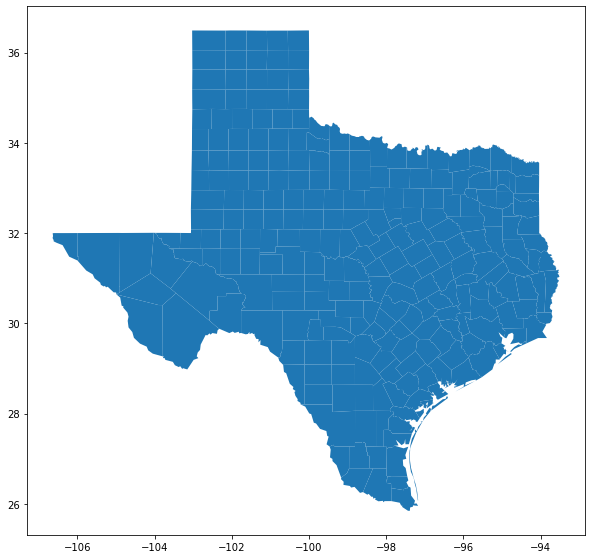

In [3]:
gdf.plot()

Print the coordinate system of `gdf`.

In [4]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The `gdf` is in a geographic coordinate system (latitude & longitude), which is not suitable for spatial analysis. You need to convert the data to a projected coordinate system (Texas State Mapping System, EPSG:3081).

### Question 1 (2pts): Please convert the geographic coordinate system of "gdf" to a projected coordinate system (EPSG:3081) which better fits Texas. Please store the converted dataset in "gdf2".

- You may refer to [Lab4_A](https://github.com/qiang-yi/spatial_data_science/blob/main/Lab4_A_answer.ipynb) about how to do the conversion.

<AxesSubplot:>

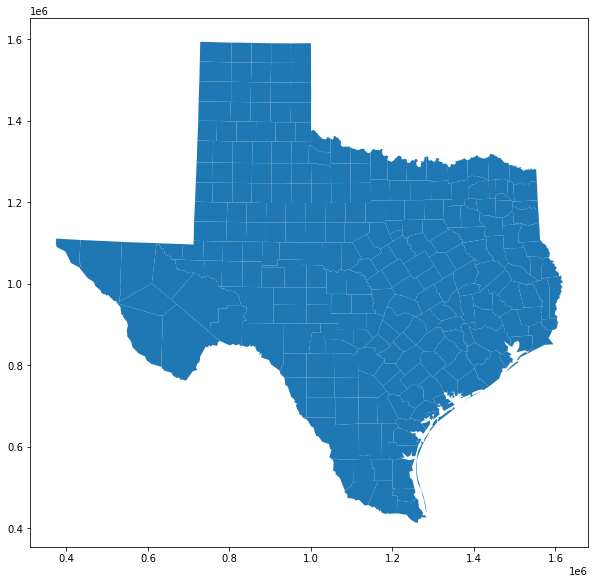

In [5]:
# Convert the crs to EPSG:3081 (Texas State Mapping System)
gdf2 = gdf.to_crs(3081)

# Plot gdf2
gdf2.plot()

### Question 2 (2pts): Use "gdf2" to create a choropleth map to display median age in the Texas counties.

- You are free to choose the number of classes, color scheme and classification method.
- Add a convextly basemap in the background of the choropleth map.

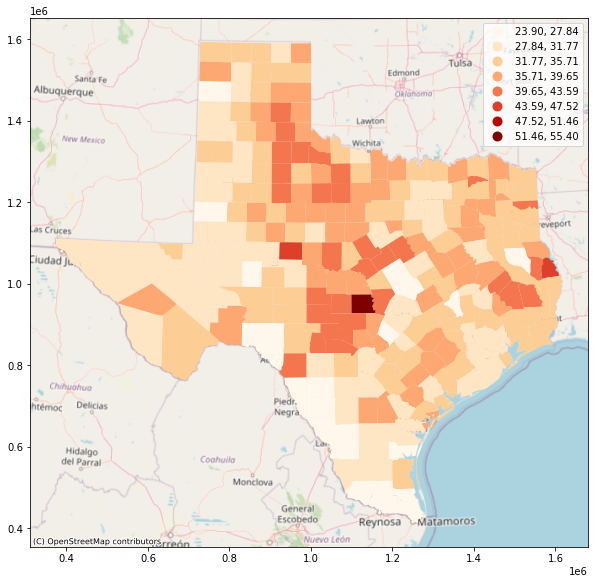

In [6]:
# Import the contextily library
import contextily as cx

# Create a choropleth map for 'median_pri', and save map in a canvas "ax"
ax1 = gdf2.plot(column='MA90', cmap='OrRd', scheme='EqualInterval', k = 8, legend = True, legend_kwds={'loc': 'upper right'});

# Adding a basemap (OpenStreetMap.Mapnik) to the canvas.
cx.add_basemap(source = cx.providers.OpenStreetMap.Mapnik, crs=gdf2.crs, ax = ax1)

## 3. Spatial Weight Matrix

As you learned in class, neighborhoods (nearness) can be defined in three different ways: 
- Contiguity (binary) 
- Distance threshold (binary) 
- Distance decay function (continuous).

Next, we will create a spatial weight matrix using **Rook** contiguity. We will use 

![](https://raw.githubusercontent.com/qiang-yi/spatial_data_science/main/image/wk10/contiguity.jpg)

In [7]:
# Import the Queen and Rook objects
from libpysal.weights.contiguity import Queen, Rook

# Create Rook contiguity 
wr = Rook.from_dataframe(gdf2)

Print the weights of each county. 

Note, this is a simplified weight matrix, where the 1s indicate neighbors of each polygon. The column index is not order. For example, the first polygon (county) has three neighbors in Queen contiguity.

We can use lines to link the centroids of the county polygons. The counties that are in rook contiguity are linked.

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

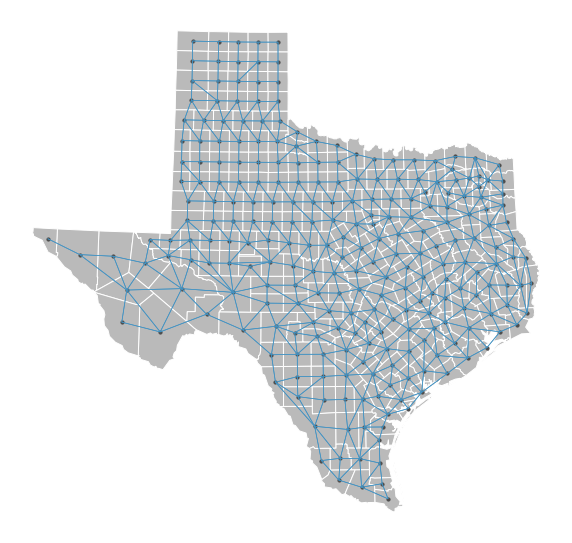

In [8]:
# Import the needed function
from splot.libpysal import plot_spatial_weights

# Plot the neighborhood relations
plot_spatial_weights(wr, gdf2)

We can also create and plot neighborhood relations in **Queen** contiguity.

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

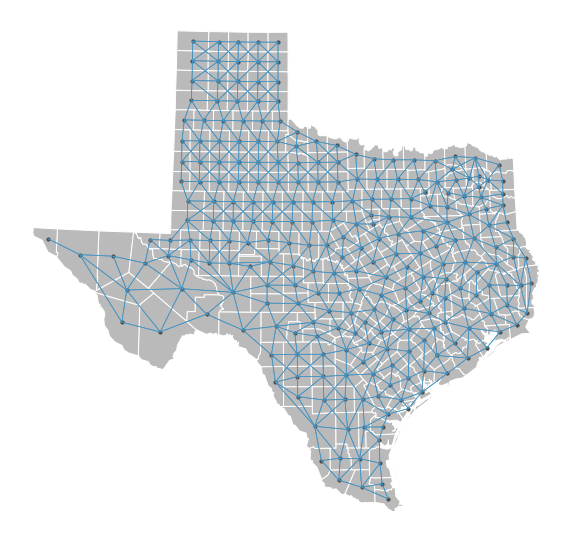

In [9]:
# Create Queen contiguity 
wq = Queen.from_dataframe(gdf2)

# Plot the neighbors in Queen contiguity
plot_spatial_weights(wq, gdf2)

You can compare the difference between the neighborhood networks in Rook and Queen contiguity.

Print the weights in the queen contiguity. This is a simplified weight matrix, where the 1s represent neighbors (Queen contiguity) of each polygon. The column index is not ordered.

In [10]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0],
 28: [1.0, 1.0, 1.0, 1.0, 1.0

Next, we standardize the weights by row sums. This is done by dividing numbers in the weight matrix by the sum of rows. See the following figure to learn how the standardization works.

![](https://raw.githubusercontent.com/qiang-yi/spatial_data_science/main/image/wk10/weight.jpg)

In [11]:
# Standardize the weights by rows
wq.transform = 'r'

Check the weights in the matrix. You can see the weights become decimal numbers, which are divisions of 1s by the row sums.

In [12]:
wq.weights

{0: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 1: [0.2, 0.2, 0.2, 0.2, 0.2],
 2: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 3: [0.2, 0.2, 0.2, 0.2, 0.2],
 4: [0.2, 0.2, 0.2, 0.2, 0.2],
 5: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 6: [0.2, 0.2, 0.2, 0.2, 0.2],
 7: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 8: [0.2, 0.2, 0.2, 0.2, 0.2],
 9: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 10: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 11: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 12: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 13: [0.2, 0.2, 0.2, 0.2, 0.2

## 4. Spatial Similarity

In the previous step, we created the spatial weight matrix to quantify "nearness" of spatial locations. Next, we will analyze the similarity of values in locations near each other. In other words, we will analyze the correlation between a value and the weighted average of values in the neighborhood (spatial lag).

![](image/wk10/spatial_lag.jpg)

First, store the median ages in 1990 in `y`.

In [13]:
y = gdf2['MA90']

Calculate the spatial lag of `y`, which are average median ages in the neighbors. Here we use the Queen contiguity (`wq`) to define neighbors.

In [14]:
# Calculate spatial lag of y
ylag = lps.weights.lag_spatial(wq, y)

# Create a new column to store ylag
gdf2['lag_MA90'] = ylag

Next, create a choropleth map to show the spatial lags of median ages in Texas.


### Question 3 (2pts): Create a choropleth map to show the spatial lag of median age (lag_MA90).

- You are free to choose the number of classes, color scheme and classification method.
- The choropleth map needs to be placed on top of a basemap.

Text(0.5, 1.0, 'Spatial Lag Median Price (Quintiles)')

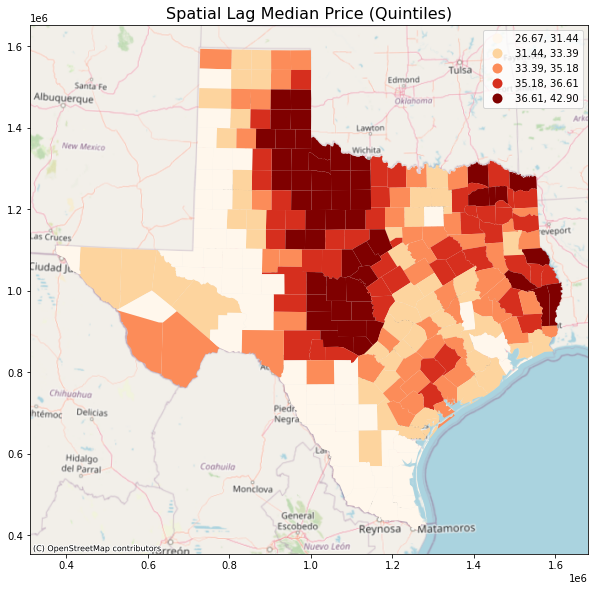

In [15]:
ax2 = gdf2.plot(column='lag_MA90', scheme='quantiles', k=5, cmap='OrRd', legend=True)

# Adding a basemap (OpenStreetMap.Mapnik) to the canvas.
cx.add_basemap(source = cx.providers.OpenStreetMap.Mapnik, crs=gdf2.crs, ax = ax2)

# Add a title to the plot
ax2.set_title("Spatial Lag Median Price (Quintiles)",fontsize = 16)

For comparison, we can combine the two choropleth maps of median age and the spatial lag of median age in one plot. Spatial autocorrelation is the correlation between the two maps.

(310938.42891080485, 1680411.6734600938, 354617.6517462521, 1652971.636944376)

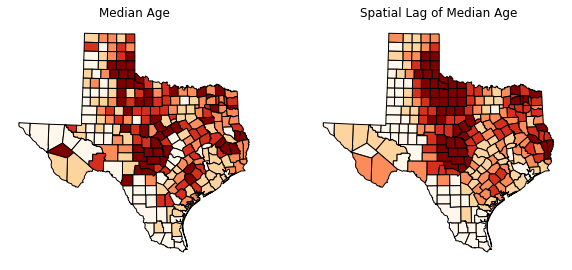

In [16]:
# Create an empty figure and canvas with two subplots
# ax is a list containing two elements
f,ax = plt.subplots(1,2)

# Create a choropleth map for median age (MA90), and store the map in ax[0] 
gdf2.plot(column='MA90', ax=ax[0], edgecolor='k',scheme="quantiles",  k=5, cmap='OrRd')
ax[0].set_title("Median Age")

# Create a choropleth map for the spatial lag of median age (lag_MA90), and store the map in ax[1] 
gdf2.plot(column='lag_MA90', ax=ax[1], edgecolor='k',scheme='quantiles', k=5, cmap='OrRd')
ax[1].set_title("Spatial Lag of Median Age")

# Turn off axes
ax[0].axis('off')
ax[1].axis('off')

## 5. Spatial Autocorrelation

We can use a scatter plot to examine the correlation between median age and the spatial lag of median age. The plot below shows an example in positive spatial autocorrelation, where most points are located in the Low-Low and High-High quadrats. This means that similar values are neighbors of each other.

![](https://raw.githubusercontent.com/qiang-yi/spatial_data_science/main/image/wk10/sa.jpg)

Next, we create a scatter plot for MA90 and lag_MA90 in `gdf2`.

Text(0.5, 0, 'Median age')

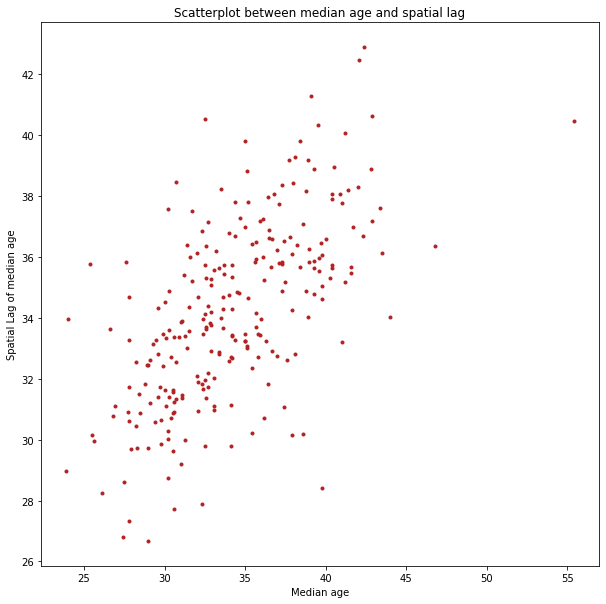

In [17]:
# Create the scatter plot
plt.plot(y, ylag, '.', color='firebrick')

# Add title and labels to the plot
plt.title('Scatterplot between median age and spatial lag')
plt.ylabel('Spatial Lag of median age')
plt.xlabel('Median age')

The points in the scatter plot shows an increasing trend, indicating that spatial lag increases with the variable itself. 

Next, we create a regression line to describe the trend. To do this, we fit the `y` and `ylag` into a linear regression model:

```math
ylag = b*y + e

```


In [18]:
b, e = np.polyfit(y, ylag, 1)

print("Regression coefficient (b): "+str(b))
print("Residual (e): "+str(e))

Regression coefficient (b): 0.40889451330631826
Residual (e): 20.197208433649273


<i>b</i> is positive, meaning the regression line is tilting up (positive spatial autocorrelation).

Next, we add the regression line into the scatter plot. We also divide the plot into four quadrats, including high-high, low-low, high-low, and low-high

Text(0.5, 0, 'Median age')

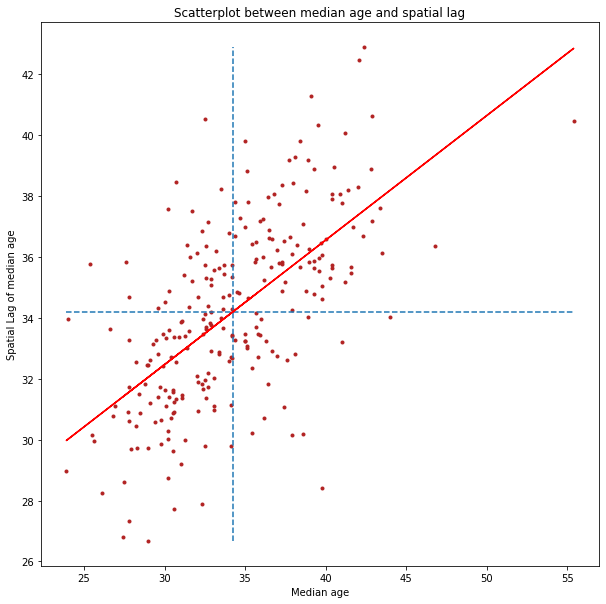

In [19]:
ax = plt.subplot()

b, e = np.polyfit(y, ylag, 1)

plt.plot(y, ylag, '.', color='firebrick')

# dashed vertical at mean of the price
plt.vlines(y.mean(), ylag.min(), ylag.max(), linestyle='--')

# dashed horizontal at mean of lagged price 
plt.hlines(ylag.mean(), y.min(), y.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y, e + b*y, 'r')
plt.title('Scatterplot between median age and spatial lag')
plt.ylabel('Spatial Lag of median age')
plt.xlabel('Median age')

## 6. Moran's <i>I</i>

The regression coefficient <i>b</i> is equavalent to Moran's <i>I</i>. 

The above steps demonstrate how <i>b</i> is computed from scratch. An easier way is using the `moran.Moran` function in the `esda` package to calculate Moran's <i>I</i>. The following code compute Moran's <i>I</i> of median age (`MA90`).

In [20]:
# Compute Moran's I
mi = esda.moran.Moran(gdf2['MA90'], wq)

# Print Moran's I
mi.I

0.40889451330631843

As you can see, Moran's <i>I</i> is equal to the regression coefficient <i>b</i> computed previously.

The <i>p</i>-value of Moran's <i>I</i> indicates the probability (or confidence) that the spatial pattern of median age is NOT random. The smaller the <i>p</i>-value is, the more significant the spatial pattern is.

In [21]:
# Print the p-value of Moran's I
mi.p_sim

0.001

The <i>p</i>-value is very small, indicating a high probability the pattern is not random, but is a positive spatial autocorrelation (Morna's <i>I</i> > 0). Usually, a <i>p</i>-value smaller than 0.05 is a threshold to determine the pattern is not random (significant). 

The following code compares the Moran's <i>I</i> of median age with a random distribution. The histogram shows that the Moran's _I_ of `MA90` (red mark) is positively deviated from the mean of the random distribution (black mark), indicating the spatial autocorrelation is significantly positive.

Text(0.5, 0, "Moran's I")

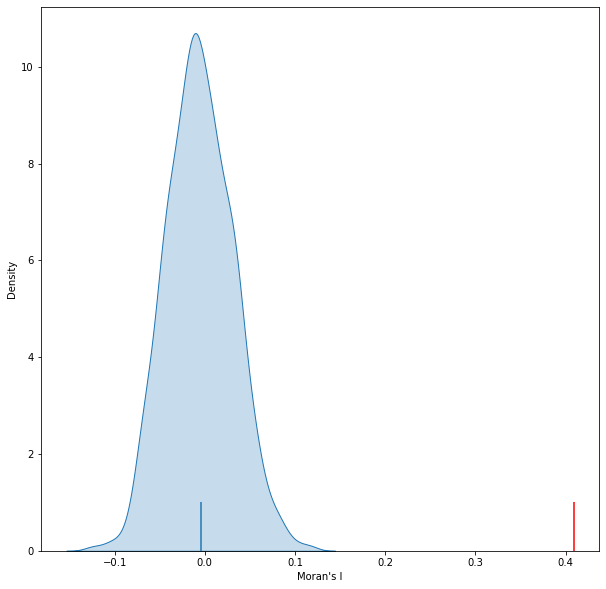

In [22]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

## 7. Local Spatial Autocorrelation: Hot Spots, Cold Spots, and Outliers¶

The Moran's _I_ derived in the last step is a single, global statistic describing the overal spatial pattern of the variable (MA90). However, you can observe heterogenous pattersns at local areas. In some places, similar values are located near each other (positive SA). In some other places, dissimilar values are near each other (negative SA).

To detect local patterns, local Moran's _I_ can be calculated at each polygon, indicating spatial autocorrelation in the neighborhood of the polygon.

Calculate local Moran's _I_ using the Queen contiguity.

In [23]:
# Calculate local Moran's I
li = esda.moran.Moran_Local(y, wq)

# Print local Moran's I.
li.Is

array([-5.79859022e-02, -7.54709966e-03,  4.25483810e-02,  8.62888094e-02,
       -1.32018810e-02,  1.89369529e-02, -3.11435760e-02,  1.01534210e-02,
       -4.80034194e-01,  2.64720176e-01,  1.18677280e-01,  7.47782553e-03,
        2.69833572e-01,  5.95336475e-01,  7.80059585e-01,  2.23510523e-01,
        2.86323733e-01,  1.11601129e+00,  1.52002109e+00,  1.28914633e+00,
        6.48781805e-01,  7.73820677e-01,  1.57339131e-03,  1.13364410e+00,
        1.54511660e+00,  2.66177379e+00,  1.11124112e+00,  1.65267622e-01,
        1.48599361e+00,  1.94647736e+00, -1.25711282e-01,  6.36583507e-01,
        2.99259322e-02,  3.40970203e-01,  1.22527927e+00, -4.01104874e-01,
        2.25854200e-01,  3.31180607e-01,  3.64667903e-01, -3.70861309e-02,
       -6.73557983e-05,  1.89617079e-01,  1.40354258e-01, -5.26711455e-01,
        9.48441167e-01, -8.35760685e-02,  6.31469975e-01,  6.73909609e-02,
        7.47541280e-01,  8.22326732e-01,  1.22199888e+00,  6.20862292e-01,
       -2.95094847e-02,  

Print which quadrant (pattern) does each polygon belongs to. The numbers mean:
- 1:High-High 
- 2:Low-High
- 3:Low-Low
- 4:High-Low

In [24]:
li.q

array([4, 4, 3, 3, 2, 1, 2, 3, 4, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 1, 2, 1, 1, 1, 4, 2, 1, 1, 2,
       1, 2, 3, 1, 3, 1, 1, 3, 2, 1, 1, 3, 3, 2, 3, 2, 1, 1, 1, 1, 1, 1,
       2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 1, 1, 1, 1, 2, 4, 3, 1,
       3, 2, 1, 3, 1, 2, 2, 3, 2, 4, 3, 2, 3, 1, 1, 1, 3, 3, 1, 2, 4, 1,
       4, 2, 2, 1, 1, 4, 4, 3, 3, 3, 4, 3, 3, 1, 1, 1, 2, 1, 1, 3, 3, 4,
       3, 3, 1, 3, 2, 1, 1, 2, 2, 3, 1, 3, 3, 3, 4, 1, 4, 1, 3, 2, 4, 1,
       1, 1, 1, 3, 3, 3, 2, 1, 1, 4, 4, 3, 2, 1, 3, 1, 2, 1, 3, 1, 1, 3,
       1, 3, 4, 1, 3, 3, 4, 3, 3, 3, 2, 2, 1, 1, 3, 3, 3, 3, 2, 2, 1, 3,
       3, 3, 1, 3, 1, 4, 1, 3, 4, 1, 1, 3, 3, 3, 2, 2, 3, 1, 3, 3, 4, 3,
       3, 3, 1, 4, 3, 3, 3, 2, 3, 3, 3, 4, 4, 2, 3, 4, 3, 4, 2, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Print the p-values of Local Moran's _I_. Counties where _p_<0.05 have a significant pattern.

In [25]:
li.p_sim

array([0.394, 0.32 , 0.421, 0.256, 0.471, 0.404, 0.268, 0.187, 0.066,
       0.221, 0.306, 0.343, 0.037, 0.078, 0.102, 0.068, 0.193, 0.007,
       0.011, 0.013, 0.054, 0.061, 0.336, 0.007, 0.007, 0.001, 0.018,
       0.036, 0.027, 0.001, 0.182, 0.042, 0.005, 0.068, 0.023, 0.075,
       0.229, 0.268, 0.19 , 0.323, 0.468, 0.022, 0.351, 0.001, 0.059,
       0.233, 0.052, 0.039, 0.033, 0.005, 0.041, 0.062, 0.163, 0.116,
       0.175, 0.46 , 0.171, 0.167, 0.331, 0.11 , 0.018, 0.017, 0.026,
       0.189, 0.01 , 0.081, 0.306, 0.093, 0.007, 0.037, 0.044, 0.16 ,
       0.176, 0.185, 0.152, 0.171, 0.475, 0.074, 0.05 , 0.172, 0.163,
       0.021, 0.091, 0.201, 0.114, 0.284, 0.068, 0.052, 0.034, 0.19 ,
       0.4  , 0.492, 0.159, 0.285, 0.133, 0.455, 0.402, 0.239, 0.419,
       0.049, 0.17 , 0.169, 0.123, 0.11 , 0.041, 0.023, 0.086, 0.012,
       0.281, 0.387, 0.452, 0.26 , 0.31 , 0.47 , 0.037, 0.28 , 0.339,
       0.375, 0.016, 0.002, 0.497, 0.107, 0.013, 0.13 , 0.223, 0.002,
       0.118, 0.132,

Select counties where Moran's _I_ is statistically significant (_p_ <0.05). There are four situations:
- High-High (Hotspot): high values are surrounded by high values 
- Low-Low (Coldspot): low values are surrounded by low values
- Low-High: low values are surrounded by high values
- High-Low: high values are surrounded by low values


In [26]:
hotspot = gdf2[(li.p_sim<0.05) & (li.q==1)]
low_high = gdf2[(li.p_sim<0.05) & (li.q==2)]
coldspot = gdf2[(li.p_sim<0.05) & (li.q==3)]
high_low = gdf2[(li.p_sim<0.05) & (li.q==4)]


Plot the hot spots.

<AxesSubplot:>

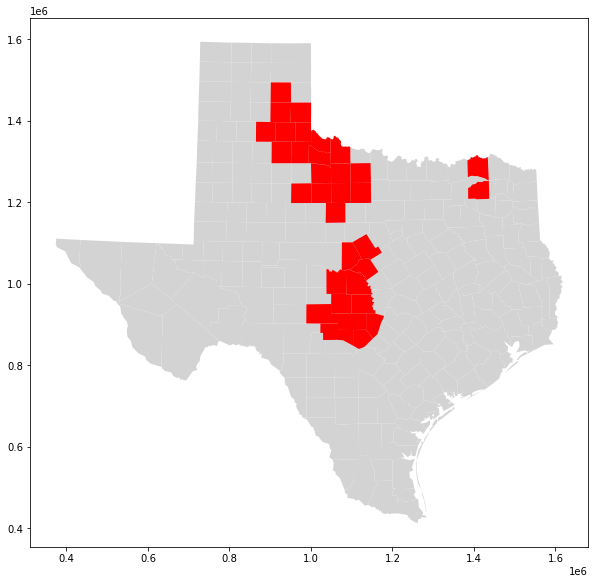

In [27]:
# Create an empty canvas
ax3 = plt.subplot()

# Plot all counties.
gdf2.plot(color='lightgray', ax=ax3)

# Plot the hotspots. 
hotspot.plot(color='red', ax=ax3)

### Question 4 (2pts): Modify the above code to plot the the cold spots in a map.

- The blue spots should be colored in blue, and other counties are in light gray.

### Question 5 (2pts): Plot all the four types of patterns (hot spots, cold spots, low-high, and high-low) in a single map.

**Requirements**: 

- Please use the following color for the four patterns:
    - hot spots: red
    - cold spots: blue
    - low-high: lightblue
    - high-low: pink
    - other (not significant): lightgray
- Plot all counties in gray under the four patterns.
- Add a convextly basemap in the background.

The created map should look like the following:
![](https://raw.githubusercontent.com/qiang-yi/spatial_data_science/main/image/wk10/lisa.jpg)

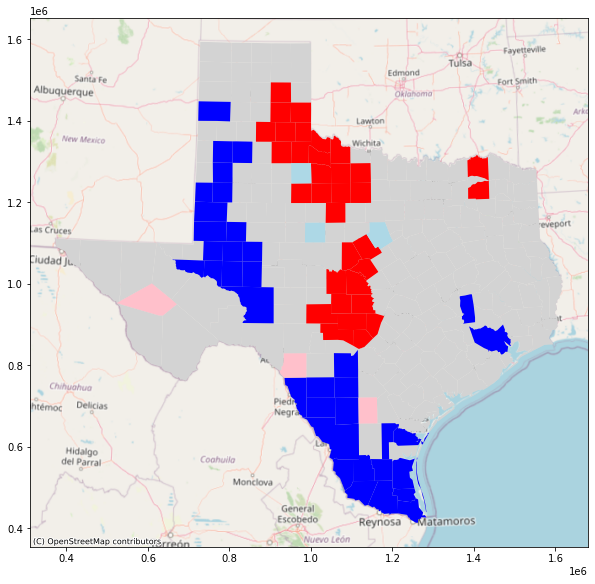

In [28]:
# Create an empty canvas
ax3 = plt.subplot()

# Plot all counties.
gdf2.plot(color='lightgray', ax=ax3)

# Plot the hot spots. 
hotspot.plot(color='red', ax=ax3)

# Plot the cold spots.
coldspot.plot(color='blue', ax=ax3)

# Plot low-high spots.
low_high.plot(color='lightblue', ax=ax3)

# Plot the high-low spots.
high_low.plot(color='pink', ax=ax3)

# Adding a basemap (OpenStreetMap.Mapnik) to the canvas.
cx.add_basemap(source = cx.providers.OpenStreetMap.Mapnik, crs=gdf2.crs, ax=ax3)